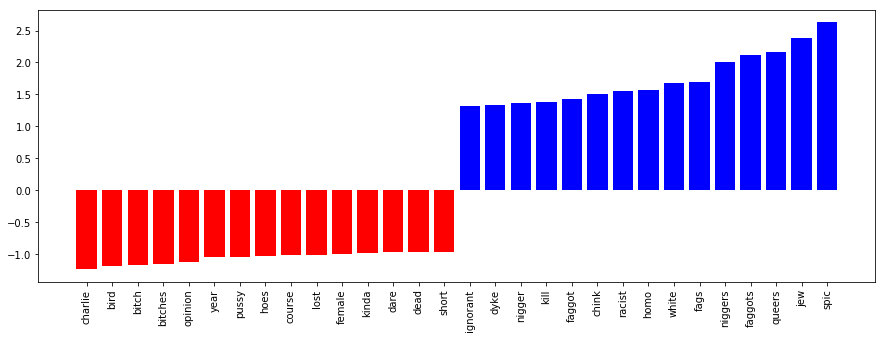

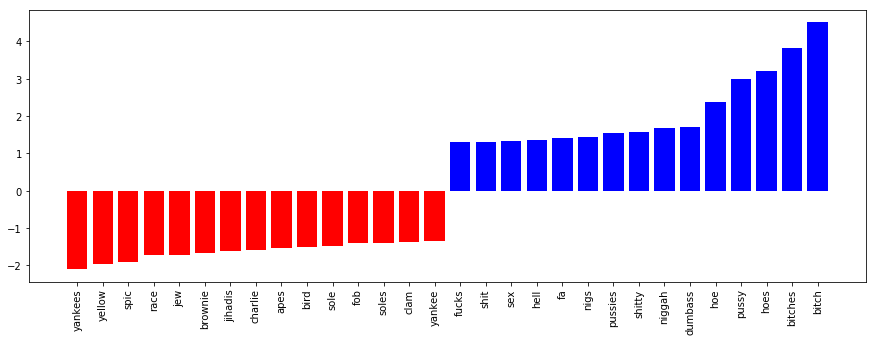

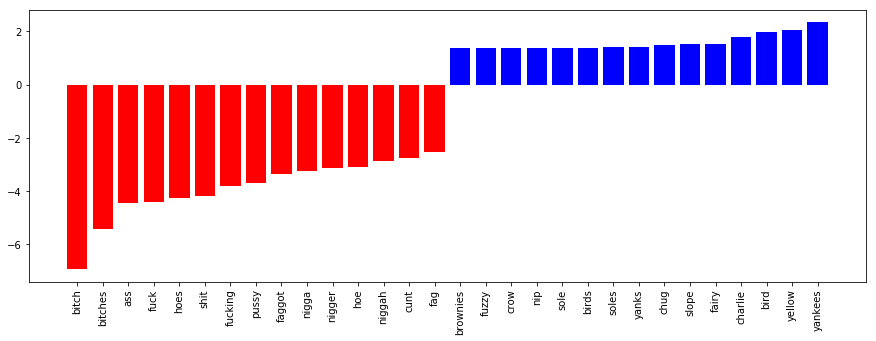

Train error: 0.07263336292470342
Test error: 0.09636026148010653


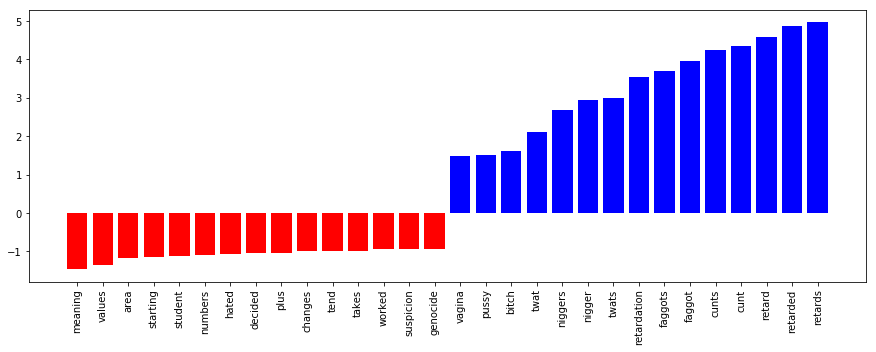

Train error: 0.093442035477513
Test error: 0.13224621449690888


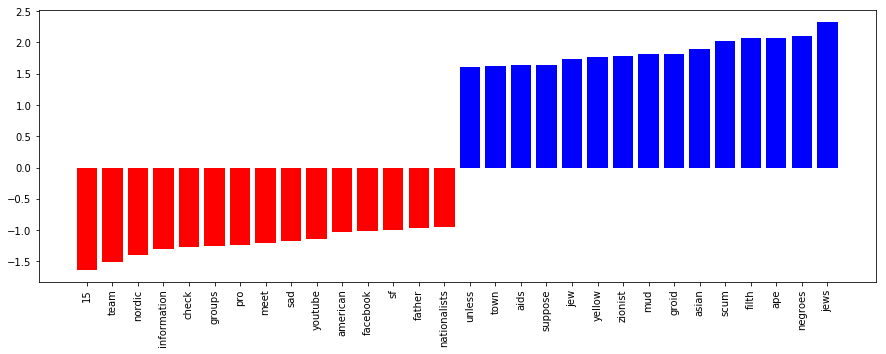

Train error: 0.11024033437826541
Test error: 0.301255230125523


In [13]:
import random
import collections
import math
import sys
import numpy as np
import csv
import pandas as pd
import string
import html
import matplotlib.pyplot as plt
import re
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

def formatData(pathName):
    trainData = pd.read_csv(pathName)
    col = ['tweet', 'class']
    trainData = trainData[col]
    trainData = trainData[pd.notnull(trainData['tweet'])]
    trainData.columns = ['tweet', 'class']
    id_to_category = dict(trainData[['class', 'tweet']].values)
    trainData.head()
    return trainData
     
def getWeights(text, weights, featureNames, f):
    words = text.split()
    for word in words:
        if (word in featureNames):
            indexOfWord = featureNames.index(word)
            weight = weights[indexOfWord]
            print(word, weight, file=f)
        
def evaluatePredictor(xData, yData, predictor, asciiX, start, end, vectorizer, pathname):
    '''
    predictor: a function that takes an x and returns a predicted y.
    Given a list of examples (x, y), makes predictions based on |predict| and returns the fraction
    of misclassiied examples.
    '''
    #figure out indexes for yTrain vs yTest
    error = 0
    yPred = predictor.predict(xData)
    f = open(pathname, "w")
    coef = predictor.coef_
    featureNames = vectorizer.get_feature_names()
    index = 0
    for i in range(start, end):
        if (yPred[index] != yData[index]):
            error += 1
            print(asciiX[i], file=f)
            print('Truth: ', yData[index], 'Prediction: ', yPred[index], file=f)
            getWeights(asciiX[i], coef[0], featureNames, f)
            print('\n', file=f)
        index += 1
    return 1.0 * error / len(yData)

def htmlConvert(data, start, end):
    asciiData = data.copy()
    for i in range(start, end): 
        x = data[i]
        x = html.unescape(x)
        x = re.sub(r"http\S+", "", x)
        asciiData[i] = x
    return asciiData

def plotCoefficients(classifier, feature_names, top_features=15):
    for i in range(len(classifier.coef_)):
        coef = classifier.coef_[i].ravel()
        top_positive_coefficients = np.argsort(coef)[-top_features:]
        top_negative_coefficients = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

        # create plot
        plt.figure(figsize=(15, 5))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='center')
        plt.show()

def analyzeTwitter():            
    # Twitter set
    data = formatData('hatespeechdata.csv')
    halfDataLen = int(len(data)/2)
    trainData = data[0:halfDataLen]
    testData = data[halfDataLen+1:]

    xTrain = trainData['tweet']
    yTrain = trainData['class']
    xTest = testData['tweet']
    yTest = testData['class']
    yTest = yTest.reset_index(drop=True)

    #     Make sure all the html encodings are output as valid text i.e. &amp as "&", takes care of emojis
    asciiX = htmlConvert(xTrain, 0, halfDataLen)
    asciiXTest = htmlConvert(xTest, halfDataLen + 1, len(data))
    features = tfidf.fit_transform(asciiX).toarray()

    vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')
    tfidfconverter = TfidfTransformer()

    #Train data
    xTrainCounts = vectorizer.fit_transform(asciiX)
    xTrainTfidf = tfidfconverter.fit_transform(xTrainCounts)
    classifier = svm.LinearSVC().fit(xTrainTfidf, yTrain)
    plotCoefficients(classifier, vectorizer.get_feature_names())

    #Format test data
    xTestCounts = vectorizer.transform(asciiXTest)
    xTestTfidf = tfidfconverter.transform(xTestCounts)

    #Train 1 v rest on train data, and run on test data
    trainError = evaluatePredictor(xTrainTfidf, yTrain, classifier, asciiX, 0, halfDataLen, vectorizer, "error-analysis-twitter-train.txt") 
    testError = evaluatePredictor(xTestTfidf, yTest, classifier, asciiXTest, halfDataLen+1, halfDataLen+len(asciiXTest), vectorizer, "error-analysis-twitter-test.txt")

    print("Train error:", trainError)
    print("Test error:", testError)
 
             
def formatRedditData(pathname):
    comments = []
    rate = []
    with open(pathname, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            lines = row['text'].splitlines()
            for i in range(len(lines)): 
                x = lines[i]
                x = html.unescape(x)
                x = re.sub(r"http\S+", "", x)
                comments.append(x)
            ids = row['hate_speech_idx']
            ratings = [1 if str(i+1) in ids else 0 for i in range(len(lines))]
            rate += ratings
    d = {'comments': comments, 'class': rate}
    formatted = pd.DataFrame(data=d)
    return formatted
             
def analyzeReddit():
    data = formatRedditData('reddit.csv')
    halfDataLen = int(len(data)/2)
    trainData = data[0:halfDataLen]
    testData = data[halfDataLen+1:]

    xTrain = trainData['comments']
    yTrain = trainData['class']
    xTest = testData['comments']
    yTest = testData['class']
    yTest = yTest.reset_index(drop=True)

    #     Make sure all the html encodings are output as valid text i.e. &amp as "&", takes care of emojis
    asciiX = htmlConvert(xTrain, 0, halfDataLen)
    asciiXTest = htmlConvert(xTest, halfDataLen + 1, len(data))
    features = tfidf.fit_transform(asciiX).toarray()

    vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')
    tfidfconverter = TfidfTransformer()

    #Train data
    xTrainCounts = vectorizer.fit_transform(asciiX)
    xTrainTfidf = tfidfconverter.fit_transform(xTrainCounts)
    classifier = svm.LinearSVC().fit(xTrainTfidf, yTrain)
    plotCoefficients(classifier, vectorizer.get_feature_names())

    #Format test data
    xTestCounts = vectorizer.transform(asciiXTest)
    xTestTfidf = tfidfconverter.transform(xTestCounts)

    #Train 1 v rest on train data, and run on test data
    trainError = evaluatePredictor(xTrainTfidf, yTrain, classifier, asciiX, 0, halfDataLen, vectorizer, "error-analysis-reddit-train.txt") 
    testError = evaluatePredictor(xTestTfidf, yTest, classifier, asciiXTest, halfDataLen+1, halfDataLen+len(asciiXTest), vectorizer, "error-analysis-reddit-test.txt")

    print("Train error:", trainError)
    print("Test error:", testError)  

def analyzeStormfront():
    def getRatings(pathname):
        ratings = {}
        with open(pathname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                label = row['file_id']
                rate = row['label']
                if (rate == 'hate'):
                    rating = 1
                else:
                    rating = 0
                ratings[label + '.txt'] = rating
        return ratings

    def formatStormFrontData(pathname, ratings):
        comments = []
        rate = []
        for filename in os.listdir(pathname):
            sample = open(pathname + '/' + filename, 'r')
            if (sample):
                text = sample.read()
                comments.append(text)
                rate.append(ratings[filename])
        d = {'comments': comments, 'class': rate}
        formatted = pd.DataFrame(data=d)
        return formatted 

    ratings = getRatings('hate-speech-dataset-master/annotations_metadata.csv')
    trainData = formatStormFrontData('hate-speech-dataset-master/sampled_train', ratings)
    testData = formatStormFrontData('hate-speech-dataset-master/sampled_test', ratings)

    xTrain = trainData['comments']
    yTrain = trainData['class']
    xTest = testData['comments']
    yTest = testData['class']
    yTest = yTest.reset_index(drop=True)

    #     Make sure all the html encodings are output as valid text i.e. &amp as "&", takes care of emojis
    asciiX = htmlConvert(xTrain, 0, len(xTrain))
    asciiXTest = htmlConvert(xTest, 0, len(xTest))
    features = tfidf.fit_transform(asciiX).toarray()

    vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words='english')
    tfidfconverter = TfidfTransformer()

    #Train data
    xTrainCounts = vectorizer.fit_transform(asciiX)
    xTrainTfidf = tfidfconverter.fit_transform(xTrainCounts)
    classifier = svm.LinearSVC().fit(xTrainTfidf, yTrain)
    plotCoefficients(classifier, vectorizer.get_feature_names())

    #Format test data
    xTestCounts = vectorizer.transform(asciiXTest)
    xTestTfidf = tfidfconverter.transform(xTestCounts)

    #Train 1 v rest on train data, and run on test data
    trainError = evaluatePredictor(xTrainTfidf, yTrain, classifier, asciiX, 0, len(xTrain), vectorizer, "error-analysis-stormfront-train.txt") 
    testError = evaluatePredictor(xTestTfidf, yTest, classifier, asciiXTest, 0, len(xTest), vectorizer, "error-analysis-stormfront-test.txt")

    print("Train error:", trainError)
    print("Test error:", testError)   
             
analyzeTwitter()
analyzeReddit()
analyzeStormfront()